In [15]:
""" https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf
https://user.ceng.metu.edu.tr/~emre/resources/courses/AdvancedDL_Spring2017/DQN_Muhammed.pdf
https://www.youtube.com/watch?v=NP8pXZdU-5U&t=1s """
import matplotlib.pyplot as plt
import torch
import numpy as np
from copy import deepcopy
from tqdm import tqdm
from SnakeEnvironment import *
from Agent import *
import collections
import random
from itertools import count

TRY:
- Longer training
- More layers in NN
- Bigger layers in NN
- Different loss

In [16]:
BATCH_SIZE = 256
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.0001
EPS_DECAY = 0.00005
TARGET_UPDATE = 150
MY_SEED = 0
LR = 0.00005
MEMORY_SIZE = 1000000
# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
state_size = 16
nr_actions = 4

NR_AGENTS = 2000
NR_GAMES = 5
best_agent = None
best_avg_score = -1

avg_scores = []
for agent in tqdm(range(NR_AGENTS)):
    # Initializing agent with NEW seed
    new_agent = Agent(gamma=GAMMA,exploration_rate=EPS_START,lr=LR,
                  input_size=state_size, batch_size=BATCH_SIZE,
                  nr_actions=nr_actions, max_mem_size=MEMORY_SIZE,
                  nr_consecutive_frames=1, exploration_rate_min=EPS_END,
                  exploration_decay_rate=EPS_DECAY,seed=MY_SEED+agent)

    # Each agent plays a few games
    avg_score = 0
    for game in range(NR_GAMES):
        game_env = SnakeEnvironment(seed=MY_SEED+agent,
                                    neural_net=new_agent.policy_network,
                                    display_gameplay=False)
        game_env.run()
        avg_score += game_env.current_score/NR_GAMES

    if avg_score > best_avg_score:
        best_agent = new_agent
        best_avg_score = avg_score

    avg_scores.append(avg_score)

100%|██████████| 2000/2000 [00:14<00:00, 134.76it/s]


best_avg_score: 3.0


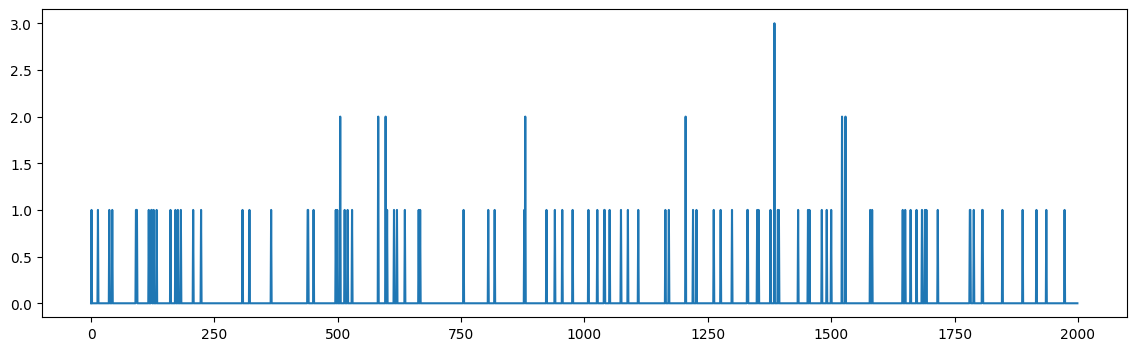

In [17]:
print("best_avg_score:", best_avg_score)
fig, ax = plt.subplots(1,1,figsize=(14,4))
ax.plot([i for i in range(len(avg_scores))], avg_scores)
plt.show()

In [18]:
NUM_EPISODES = 800

episode_durations = []
episode_rewards = []
episode_exploration_rates = []

t_total_counter = 0
for i_episode in tqdm(range(NUM_EPISODES)):
    # Initialize the environment and state
    game_env = SnakeEnvironment(seed=MY_SEED + i_episode,  # Try both constant seed and varying seed for each episode
                                display_gameplay=False)
    game_env.initialize_environment()

    current_game_score = 0
    current_game_duration = 0

    current_exploration_rate = 0
    current_steps_counter = 0
    game_over = False
    current_state = game_env.get_state()

    for t in count():
        # Select and perform an action according to greedy epsilon strategy
        action = best_agent.choose_action(current_state)

        # Perform action in game environment and observe reward and new state + termination flag.
        reward, game_over, new_observation = game_env.step(action)
        current_game_score += reward
        reward = torch.tensor([reward])

        # Observe new state
        last_state = current_state
        current_state = new_observation

        # Store the transition in memory
        # print(type(last_state), type(action),type(reward),type(current_state),type(game_over))
        best_agent.store_transition(state=last_state,action=action,
                                   reward=reward,new_state=current_state,
                                   done_flag=game_over)



        # Perform one step of the optimization (on the policy network)
        best_agent.learn()
        if game_over:
            break
        t_total_counter += 1
        current_game_duration += 1

        # Update the target network, copying all weights and biases in DQN from policy to target network
        if t % TARGET_UPDATE == 0:
            best_agent.align_networks()


    episode_rewards.append(current_game_score)
    episode_durations.append(current_game_duration)
    episode_exploration_rates.append(best_agent.exploration_rate)


100%|██████████| 800/800 [07:31<00:00,  1.77it/s]


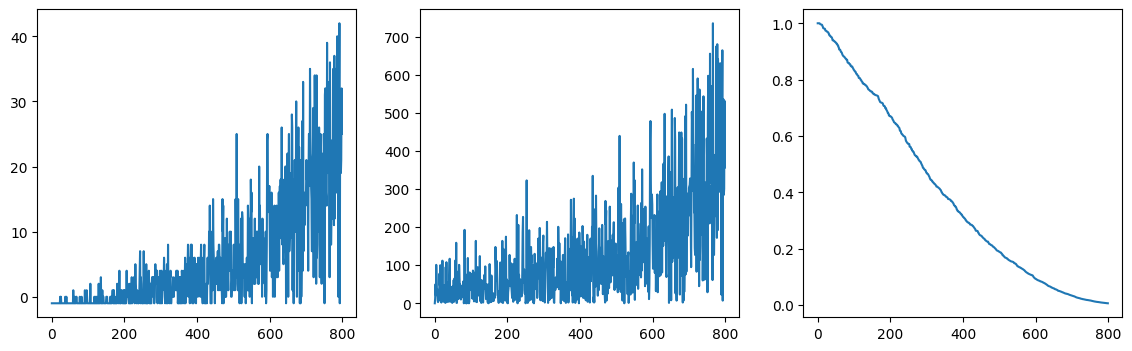

In [19]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot([i for i in range(len(episode_rewards))], episode_rewards)
ax[1].plot([i for i in range(len(episode_durations))], episode_durations)
ax[2].plot([i for i in range(len(episode_exploration_rates))], episode_exploration_rates)
plt.show()

In [20]:
avg_period = len(episode_rewards)//100
avg_episode_rewards, avg_episode_durations, avg_episode_exploration_rates = [], [], []
for period in range(0, len(episode_rewards) // avg_period):
    avg_episode_rewards.append(np.mean(episode_rewards[avg_period * period : avg_period * (period + 1)]))
    avg_episode_durations.append(np.mean(episode_durations[avg_period * period : avg_period * (period + 1)]))
    avg_episode_exploration_rates.append(np.mean(episode_exploration_rates[avg_period * period : avg_period * (period + 1)]))

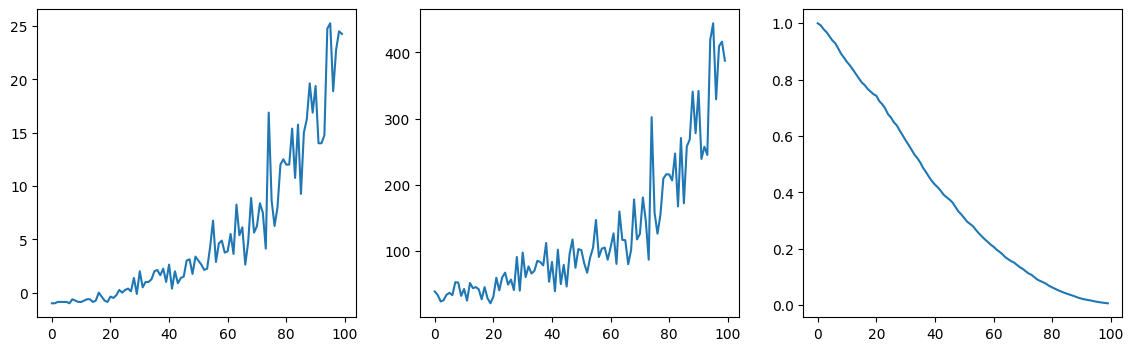

In [21]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot([ i for i in range(len(avg_episode_rewards))], avg_episode_rewards)
ax[1].plot([ i for i in range(len(avg_episode_durations))], avg_episode_durations)
ax[2].plot([ i for i in range(len(avg_episode_exploration_rates))], avg_episode_exploration_rates)
plt.show()

In [22]:
Play_game = False
if Play_game:
    game_env = SnakeEnvironment(3,  # Try both constant seed and varying seed for each episode
                                neural_net=best_agent.policy_network,
                                display_gameplay=True,
                                graphics_speed=100)
    game_env.run()

